# Sheet 8

In [2]:
import os
import numpy as np
import torch
from torch import nn
from tqdm import tqdm
from matplotlib import pyplot as plt

## 1) Anomaly detection for Autoencoders

## Preparations

### Load Data

In [3]:
# download data to folder data04
# this might take some time (50MB)
# you can also do this manually (download + unpack zip)
# import wget
# from zipfile import ZipFile
# from tqdm import tqdm

# DESTINATION = "data06"
# url = "https://www.thphys.uni-heidelberg.de/~plehn/pics/"
# filename = "toptagging-short.zip"
# url = url + filename

# os.makedirs(DESTINATION, exist_ok=True)
# os.chdir(DESTINATION)
# wget.download(url, filename)
# with ZipFile(filename, "r") as zip_ref:
#     for file in tqdm(iterable=zip_ref.namelist(), total=len(zip_ref.namelist())):
#         zip_ref.extract(member=file)
# os.chdir("..")
# %ls data06

In [4]:
# load data
X_train = np.load( "data06/toptagging-short/x_train_short.npy")
y_train = np.load( "data06/toptagging-short/y_train_short.npy")
X_test = np.load( "data06/toptagging-short/x_test_short.npy")
y_test = np.load( "data06/toptagging-short/y_test_short.npy")
X_val = np.load( "data06/toptagging-short/x_val_short.npy")
y_val = np.load( "data06/toptagging-short/y_val_short.npy")

print(f"train data shape: {X_train.shape}")
print(f"train labels shape: {y_train.shape}")
print(f"test data shape: {X_test.shape}")
print(f"test labels shape: {y_test.shape}")
print(f"val data shape: {X_val.shape}")
print(f"val labels shape: {y_val.shape}")

train data shape: (30000, 200, 4)
train labels shape: (30000,)
test data shape: (30000, 200, 4)
test labels shape: (30000,)
val data shape: (30000, 200, 4)
val labels shape: (30000,)


### Physics bit

In [5]:
# Some initial settings
__n_warning__ = 0.7
n_shift_phi, n_shift_eta = 0, 0

# Grid settings
xpixels = np.arange(-2.6, 2.6, 0.029)
ypixels = np.arange(-np.pi, np.pi, 0.035)

# Calculate the pseudorapidity of pixel entries
def eta (pT, pz):
    small = 1e-10
    small_pT = (np.abs(pT) < small)
    small_pz = (np.abs(pz) < small)
    not_small = ~(small_pT | small_pz)
    theta = np.arctan(pT[not_small]/pz[not_small])
    theta[theta < 0] += np.pi
    etas = np.zeros_like(pT)
    etas[small_pz] = 0
    etas[small_pT] = 1e-10
    etas[not_small] = np.log(np.tan(theta/2))
    return etas

# Calculate the azimuthal angle of pixel entries
def phi (px, py):
    """
    phis are returned in rad., np.arctan(0,0)=0 -> zero constituents set to -np.pi
    """
    phis = np.arctan2(py,px)
    phis[phis < 0] += 2*np.pi
    phis[phis > 2*np.pi] -= 2*np.pi
    phis = phis - np.pi 
    return phis

# function to calculate masses
def mass (E,px,py,pz):
    mass = np.sqrt(np.maximum(0.,E**2-px**2-py**2-pz**2))
    return mass

# function to return the image momenta for centroid and principal axis
def img_mom (x, y, weights, x_power, y_power):
    return ((x**x_power)*(y**y_power)*weights).sum()

# returns the jet image
def orig_image (etas, phis, es):
    """
    Gives the value on grid with minimal distance,
    eg. for xpixel = (0,1,2,3,..) eta=1.3 -> xpixel=1, eta=1.6 ->xpixel=2
    """
    z = np.zeros((etas.shape[0],len(xpixels),len(ypixels)))
    in_grid = ~((etas < xpixels[0]) | (etas > xpixels[-1]) | (phis < ypixels[0]) | (phis > ypixels[-1]))
    xcoords = np.argmin(np.abs(etas[:,None,:] - xpixels[None,:,None]),axis=1)
    ycoords = np.argmin(np.abs(phis[:,None,:] - ypixels[None,:,None]),axis=1)
    ncoords = np.repeat(np.arange(etas.shape[0])[:,None],etas.shape[1],axis=1)
    z[ncoords[in_grid],ycoords[in_grid],xcoords[in_grid]] = es[in_grid]
    return z

# preprocess the jet
def preprocessing( x ,y, weights, rotate=True, flip=True ):
    """
    (x,y) are the coordinates and weights the corresponding values, shifts
    centroid to origin, rotates image, so that principal axis is vertical,
    flips image, so that most weights lay in (x<0, y>0)-plane.
    Method for calculating principal axis (similar to tensor of inertia):
    https://en.wikipedia.org/wiki/Image_moment
    here: y=phi, phi has modulo 2*np.pi but it's not been taken care of hear,
    so possible issues with calculating the centroid
    -> pre-shifting of events outside of this function solves the problem
    for iamge-data with Delta_phi < 2*np.pi
    """

    # Shift
    x_centroid = img_mom(x, y, weights, 1, 0) / weights.sum()
    y_centroid = img_mom(x, y, weights, 0, 1)/ weights.sum()
    x = x - x_centroid
    y = y - y_centroid

    # Check if shifting worked, there can be problems with modulo variables like phi (y)
    # x and y are sorted after highest weight, 0-comp. gives hottest event
    # for Jet-like Images Centroid should be close to hottest constituen (pT-sorted arrays)  
    global n_shift_phi
    global n_shift_eta
    if np.abs(x[0]) > __n_warning__:
        n_shift_eta += 1  
    if np.abs(y[0]) > __n_warning__:
        n_shift_phi += 1       

    if rotate:
        #Ccovariant matrix, eigenvectors corr. to principal axis
        u11 = img_mom(x, y, weights, 1, 1) / weights.sum()
        u20 = img_mom(x, y, weights, 2, 0) / weights.sum()
        u02 = img_mom(x, y, weights, 0, 2) / weights.sum()
        cov = np.array([[u20, u11], [u11, u02]])

        # Eigenvalues and eigenvectors of covariant matrix
        evals, evecs = np.linalg.eig(cov)

        # Sorts the eigenvalues, v1, [::-1] turns array around, 
        sort_indices = np.argsort(evals)[::-1]
        e_1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
        e_2 = evecs[:, sort_indices[1]]

        # Theta to x_asix, arctan2 gives correct angle
        theta = np.arctan2(e_1[0], e_1[1])
  
        # Rotation, so that princple axis is vertical
        # anti-clockwise rotation matrix
        rotation = np.matrix([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
        transformed_mat = rotation * np.stack([x,y])
        x_rot, y_rot = transformed_mat.A
    else: 
        x_rot, y_rot = x, y
  
    # Flipping
    n_flips = 0
    if flip:
        if weights[x_rot<0.].sum() < weights[x_rot>0.].sum():
            x_rot = -x_rot
            n_flips  += 1
        if weights[y_rot<0.].sum() > weights[y_rot>0.].sum():
            y_rot = -y_rot
            n_flips += 1
            
    return x_rot, y_rot


# function to convert the jet to an image
def constit_to_img( jets, n_constit, norm, rotate, flip ):
    
    print( "Crop constituents" )
    jets = jets[:,0:n_constit,:]
    
    print( "Calculating pT" )
    E     = jets[:,:,0]
    pxs   = jets[:,:,1]
    pys   = jets[:,:,2]
    pzs   = jets[:,:,3]
    pT    = np.sqrt(pxs**2+pys**2)
    
    print( "Calculating eta" )
    etas  = eta(pT,pzs)
    
    print( "Calculating phi" )
    phis  = phi(pxs,pys)
    
    print( "Calculating the mass" )
    E_tot = E.sum(axis=1)
    px_tot = pxs.sum(axis=1)
    py_tot = pys.sum(axis=1)
    pz_tot = pzs.sum(axis=1)
    j_mass = mass(E_tot, px_tot, py_tot, pz_tot)
    
    print( "Pre-shifting the phis" )
    phis = (phis.T - phis[:,0]).T
    phis[phis < -np.pi] += 2*np.pi
    phis[phis > np.pi] -= 2*np.pi
    
    print( "Using pT as weight" )
    weights = pT
    
    print( "Preprocessing" )
    
    for i in range( np.shape(etas)[0] ):
        etas[i,:], phis[i,:] = preprocessing( etas[i,:], phis[i,:], weights[i,:], rotate, flip )
    
    print( "Creating images" )
    z_ori = orig_image(etas, phis, weights)
    
    #return z_ori
        
    print( "Cropping and normalising" )
    n_crop = 40
    z_new = np.zeros( (z_ori.shape[0],n_crop, n_crop) )
    for i in range(z_ori.shape[0]):
        Npix = z_ori[i,:,:].shape
        z_new[i,:,:] = z_ori[i, int(Npix[0]/2-n_crop/2) : int(Npix[0]/2+n_crop/2), int(Npix[1]/2-n_crop/2) : int(Npix[1]/2+n_crop/2) ]
        if norm:
            z_sum = z_new[i,:,:].sum()
            if z_sum != 0.:
                z_new[i,:,:] = z_new[i,:,:]/z_sum
    
    print( "Reshaping" )
    z_out = z_new.reshape( (z_new.shape[0],-1) ).reshape(-1, 1, 40,40)
    
    return z_out

In [6]:
z_train = constit_to_img( X_train, 50, True, True, True )
z_val = constit_to_img( X_val, 50, True, True, True )
z_test = constit_to_img( X_test, 50, True, True, True )

Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Creating images
Cropping and normalising
Reshaping
Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Creating images
Cropping and normalising
Reshaping
Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Creating images
Cropping and normalising
Reshaping


### Dataloaders

In [7]:
# dataset
class Jet_Dataset(torch.utils.data.Dataset):
    # no preprocessing needed (i.e. no unsqueeze) to get layers dim
    def __init__(self, data, labels):
        self.data = torch.tensor(data).to(torch.float32)
        self.labels = torch.tensor(labels).to(torch.float32)
        self.length = len(data)

    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [137]:
# dataloaders
trn_dataloader = torch.utils.data.DataLoader(Jet_Dataset(z_train, y_train), batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(Jet_Dataset(z_val, y_val), batch_size=64, shuffle=False)
tst_dataloader = torch.utils.data.DataLoader(Jet_Dataset(z_test, y_test), batch_size=64, shuffle=False)

In [138]:
def reshape_data(x):
    return x.reshape(x.shape[:1] + (-1,))

In [9]:
z_train_reshaped = reshape_data(z_train)
only_qcd = torch.utils.data.DataLoader(
    Jet_Dataset(z_train_reshaped[y_train == 0], y_train[y_train == 0]),
    batch_size=64,
    shuffle=True,
)
only_top = torch.utils.data.DataLoader(
    Jet_Dataset(z_train_reshaped[y_train == 1], y_train[y_train == 1]),
    batch_size=64,
    shuffle=True,
)

In [139]:
only_cnn_qcd = torch.utils.data.DataLoader(
    Jet_Dataset(z_train[y_train == 0], y_train[y_train == 0]),
    batch_size=64,
    shuffle=True,
)
only_cnn_top = torch.utils.data.DataLoader(
    Jet_Dataset(z_train[y_train == 1], y_train[y_train == 1]),
    batch_size=64,
    shuffle=True,
)

### CPU/GPU Device

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


## (a)
Autoencoder

In [11]:
# TODO: Construct autoencoder
class Jet_Autoencoder(nn.Module):
    def __init__(self, input_dim, bottleneck_dim, hidden_dim):
        super(Jet_Autoencoder, self).__init__()
        self.input_dim = input_dim
        self.bottleneck_dim = bottleneck_dim
        self.hidden_dim = hidden_dim
        # encoder: MLP with 2 hidden layers
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, bottleneck_dim)
        )
        # decoder: MLP with 2 hidden layers
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x):
        # encode, decode
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## (b)
Train autoencoder on QCD jets only

In [12]:
image_size = 40 * 40

In [13]:
def batch_image_loss(model, x, loss_fn):
    x = x.to(device)
    xnew = model(x)
    return loss_fn(x, xnew)

In [14]:
def train_autoencoder_epoch(model, dataloader, losses, batch_loss_fn, loss_fn, optimizer):
    # run for each epoch (and ran over all data)
    for x, y in dataloader:
        # loading in batches of batchsize
        optimizer.zero_grad()
        loss = batch_loss_fn(model, x, loss_fn)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return losses

In [15]:
# TODO: Train autoencoder on QCD jets
# Choose the bottleneck dimension between 5 and 20
# model
model = Jet_Autoencoder(
    input_dim=image_size,
    bottleneck_dim=10,
    hidden_dim=100
)
model = model.to(device)
model.train()

# loss function
loss_fn = nn.MSELoss()

# optimiser
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# training
n_epochs = 100
train_losses = []
for epoch in tqdm(range(n_epochs)):
    train_losses = train_autoencoder_epoch(
        model,
        only_qcd,
        train_losses,
        batch_image_loss,
        loss_fn,
        optimizer
    )

100%|██████████| 100/100 [02:01<00:00,  1.21s/it]


In [16]:
print(f"The model has {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters")

The model has 344,010 trainable parameters


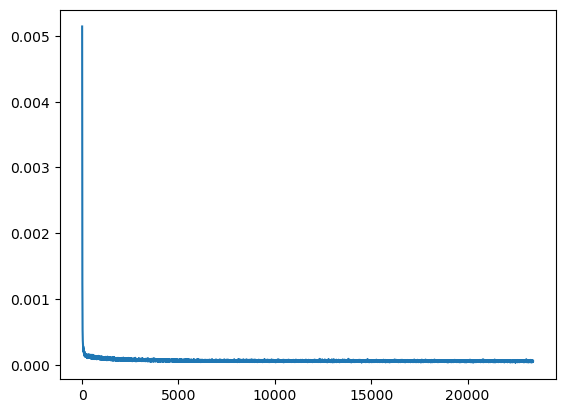

In [17]:
plt.plot(train_losses)

## (c)

In [54]:
# TODO: Visualize original vs reconstructed QCD and top jets
model.eval()
qcd_samples = torch.Tensor(z_train_reshaped[y_train == 0])
qcd_samples = qcd_samples.to(device)
qcd_reconstruction = model(qcd_samples).reshape(-1, 40, 40)
qcd_samples = qcd_samples.reshape(-1, 40, 40)

top_samples = torch.Tensor(z_train_reshaped[y_train == 1])
top_samples = top_samples.to(device)
top_reconstruction = model(top_samples).reshape(-1, 40, 40)
top_samples = top_samples.reshape(-1, 40, 40)

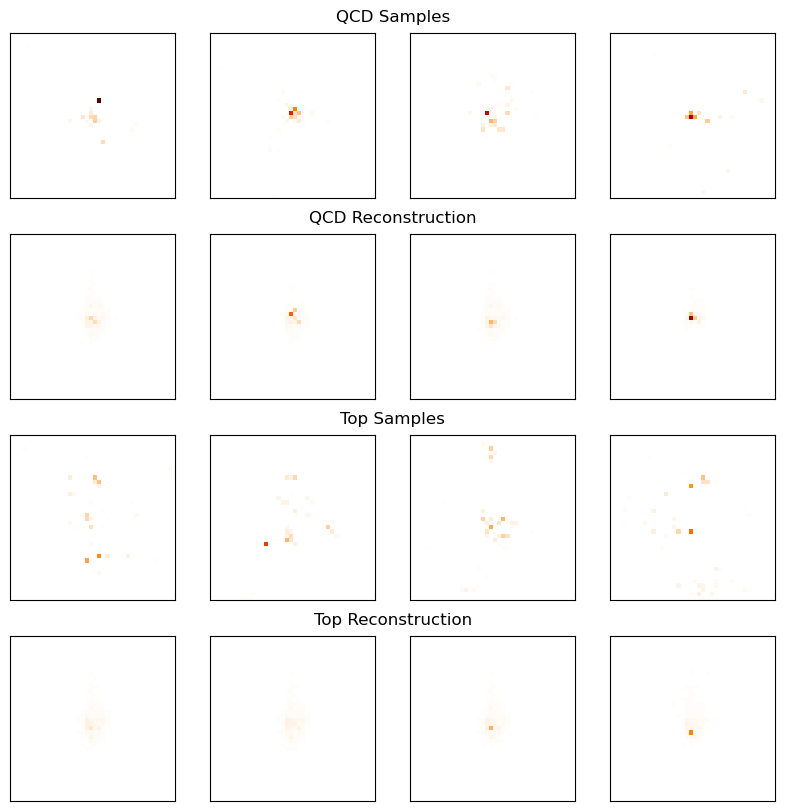

In [43]:
# Create a figure
fig = plt.figure(constrained_layout=True, figsize=(8, 8))

# Create subfigures
subfigs = fig.subfigures(4, 1)

vmin, vmax = 0, qcd_samples.max()
# Add data to the subfigures
for subfig, data, title in zip(
    subfigs.flatten(),
    [qcd_samples, qcd_reconstruction, top_samples, top_reconstruction],
    ["QCD Samples", "QCD Reconstruction", "Top Samples", "Top Reconstruction"],
):
    axes = subfig.subplots(1, 4)
    subfig.suptitle(title)
    for i, ax in enumerate(axes):
        ax.imshow(data[i].detach().cpu(), vmin=0, vmax=vmax, cmap="gist_heat_r")
        ax.set_xticks([])
        ax.set_yticks([])

plt.show()

### Discussion:
The QCD reconstructions take over the structure of the QCD samples, while the top reconstructions do not seem to be related to the top samples. They do not replicate the structure of the original sample.

This is because the network was trained exclusively on QCD images and is specialised in reproducing the structure of QCD jet images. In contrast, top jet images are unknown and it does not know how to compress the structure.

## (d)

### Visualise MSE

In [55]:
qcd_samples.shape

torch.Size([14960, 40, 40])

In [57]:
# TODO: Visualize pixel-wise MSE, plot ROC
qcd_mse = torch.mean((qcd_samples - qcd_reconstruction)**2, dim=(1, 2))
top_mse = torch.mean((top_samples - top_reconstruction)**2, dim=(1, 2))

Text(0.5, 1.0, 'MSE of Reconstruction: Comparison between QCD and Top Jets')

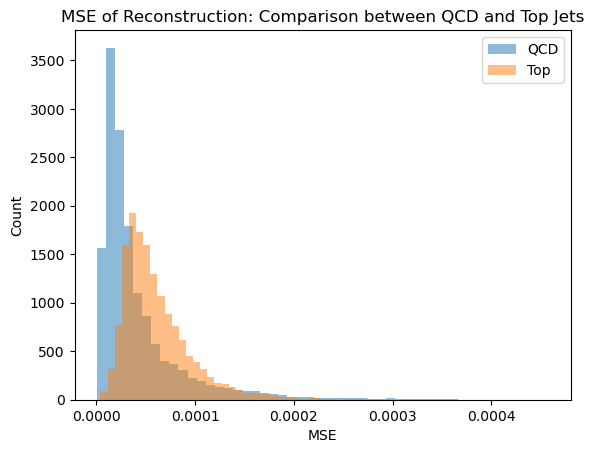

In [93]:
plt.hist(qcd_mse.detach().cpu(), bins=50, alpha=0.5, label="QCD");
plt.hist(top_mse.detach().cpu(), bins=50, alpha=0.5, label="Top");
plt.legend();
plt.xlabel("MSE")
plt.ylabel("Count")
plt.title("MSE of Reconstruction: Comparison between QCD and Top Jets")

In [82]:
def pixelwise_mse(samples, reconstruction, amount=4):
    return torch.mean((samples[:amount] - reconstruction[:amount])**2, dim=0).detach().cpu()

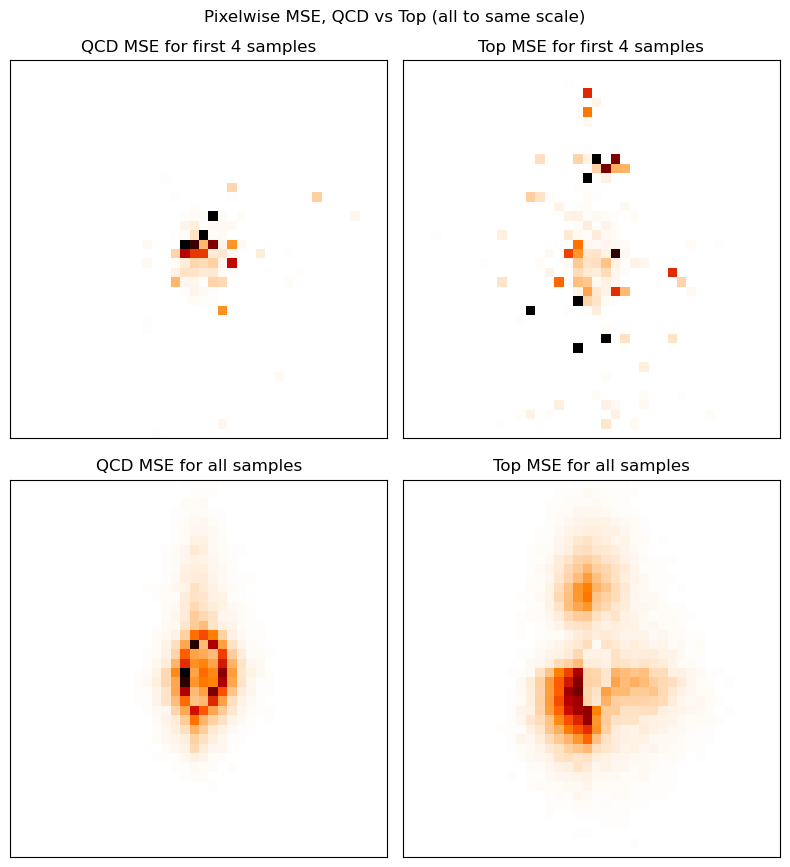

In [92]:
fig, axes = plt.subplots(2, 2, figsize=(8, 9))
vmin = 0
vmax = torch.stack(
    [
        pixelwise_mse(qcd_samples, qcd_reconstruction, -1),
        pixelwise_mse(top_samples, top_reconstruction, -1)]
    ).max()
axes[0, 0].imshow(
    pixelwise_mse(qcd_samples, qcd_reconstruction),
    vmin=vmin,
    vmax=vmax,
    cmap="gist_heat_r"
)
axes[0, 0].set_title("QCD MSE for first 4 samples")
axes[0, 1].imshow(
    pixelwise_mse(top_samples, top_reconstruction),
    vmin=vmin,
    vmax=vmax,
    cmap="gist_heat_r"
)
axes[0, 1].set_title("Top MSE for first 4 samples")
axes[1, 0].imshow(
    pixelwise_mse(qcd_samples, qcd_reconstruction, amount=-1),
    vmin=vmin,
    vmax=vmax,
    cmap="gist_heat_r"
)
axes[1, 0].set_title("QCD MSE for all samples")
axes[1, 1].imshow(
    pixelwise_mse(top_samples, top_reconstruction, amount=-1),
    vmin=vmin,
    vmax=vmax,
    cmap="gist_heat_r"
)
axes[1, 1].set_title("Top MSE for all samples")

for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

plt.suptitle("Pixelwise MSE, QCD vs Top (all to same scale)")
plt.tight_layout()

### Plot ROC
Using the TEST dataset

In [107]:
from sklearn.metrics import roc_curve, roc_auc_score

In [110]:
z_test_reshaped = torch.Tensor(reshape_data(z_test)).to(device)

We do not use a dataloader since it all works fine within memory and we do not need to batch.

In [118]:
y_test_reconstruction = model(z_test_reshaped).reshape(-1, 40, 40)
y_test_mse = torch.mean((z_test_reshaped.reshape(-1, 40, 40) - y_test_reconstruction)**2, dim=(1, 2))
y_test_mse = y_test_mse.detach().cpu().numpy()

In [122]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_mse)
auc_score = roc_auc_score(y_test, y_test_mse)

THe "true" class is the top class (with label = 1). This makes sense since we want to tag anomalies.

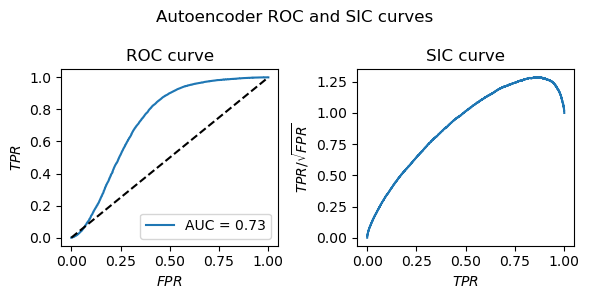

In [124]:
# create figure and two subplots
fig, ax = plt.subplots(1, 2, figsize=(6, 3))

# plot ROC curve
ax[0].plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
ax[0].plot([0, 1], [0, 1], "--", color="black")
ax[0].set_title("ROC curve")
ax[0].set_xlabel("$FPR$")
ax[0].set_ylabel("$TPR$")
ax[0].legend(loc='lower right')

# plot SIC curve
ax[1].plot(tpr[fpr != 0], tpr[fpr != 0]/np.sqrt(fpr[fpr != 0]))
ax[1].set_title("SIC curve")
ax[1].set_xlabel("$TPR$")
ax[1].set_ylabel("$TPR/\sqrt{{FPR}}$")

plt.suptitle("Autoencoder ROC and SIC curves")

plt.tight_layout()
plt.show()

## (e)
Repeat for CNN

In [165]:
# TODO: Repeat everything for CNN
class Jet_CNN_Autoencoder(nn.Module):
    def __init__(self, input_dim, bottleneck_dim, hidden_dim):
        super(Jet_CNN_Autoencoder, self).__init__()
        self.input_dim = input_dim
        self.bottleneck_dim = bottleneck_dim
        self.hidden_dim = hidden_dim
        # encoder: CNN with 2 convolutional layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.Dropout2d(0.2),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.Dropout2d(0.2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32*10*10, bottleneck_dim)
        )
        # decoder: CNN with 2 convolutional layers
        # use nn.ConvTranspose2d for upsampling (to get back original dimensions)
        # see https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, 32*10*10),
            nn.Unflatten(1, (32, 10, 10)),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
        )

    def forward(self, x):
        # encode, decode
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [196]:
modelCNN = Jet_CNN_Autoencoder(
    input_dim=image_size,
    bottleneck_dim=10,
    hidden_dim=100
)
modelCNN = modelCNN.to(device)
modelCNN.train()

# loss function
loss_fn = nn.MSELoss()

# optimiser
optimizer = torch.optim.Adam(modelCNN.parameters(), lr=1e-3)

n_epochs = 100
train_losses = []
for epoch in tqdm(range(n_epochs)):
    train_losses = train_autoencoder_epoch(
        modelCNN,
        only_cnn_qcd,
        train_losses,
        batch_image_loss,
        loss_fn,
        optimizer
    )

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [07:14<00:00,  4.34s/it]


In [197]:
print(f"The model has {sum(p.numel() for p in modelCNN.parameters() if p.requires_grad):,} trainable parameters")

The model has 76,779 trainable parameters


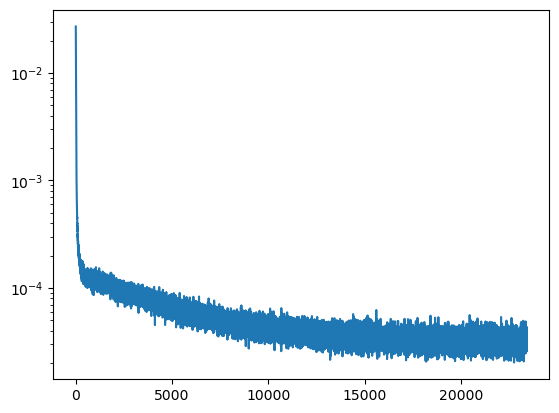

In [207]:
plt.plot(train_losses)
plt.yscale("log")

In [199]:
# TODO: Visualize original vs reconstructed QCD and top jets
modelCNN.eval()
qcd_samples = torch.Tensor(z_train[y_train == 0])
qcd_samples = qcd_samples.to(device)
qcd_reconstruction = modelCNN(qcd_samples).reshape(-1, 40, 40)
qcd_samples = qcd_samples.reshape(-1, 40, 40)

top_samples = torch.Tensor(z_train[y_train == 1])
top_samples = top_samples.to(device)
top_reconstruction = modelCNN(top_samples).reshape(-1, 40, 40)
top_samples = top_samples.reshape(-1, 40, 40)

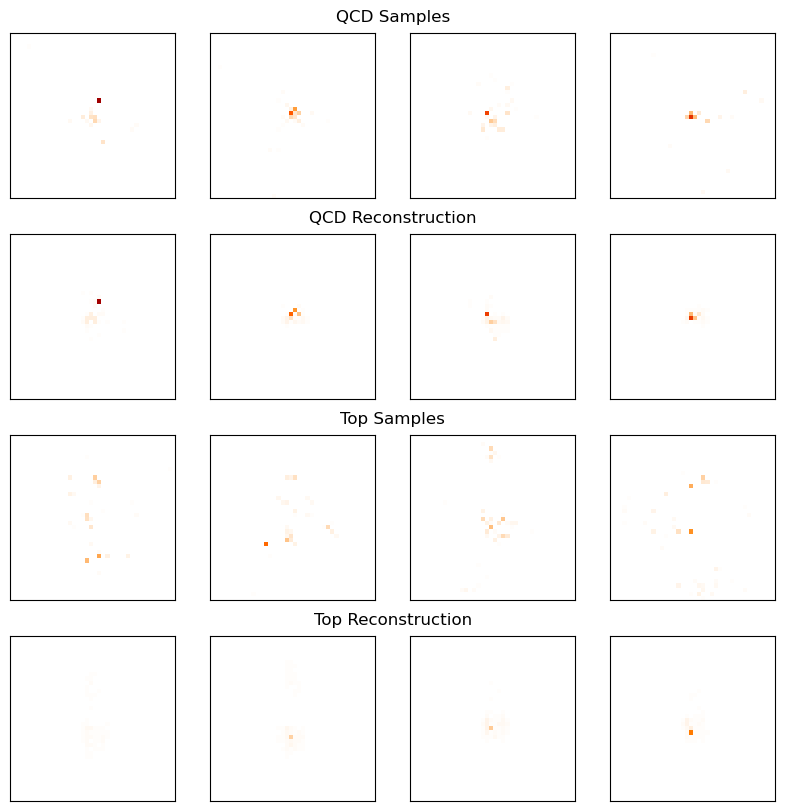

In [200]:
# Create a figure
fig = plt.figure(constrained_layout=True, figsize=(8, 8))

# Create subfigures
subfigs = fig.subfigures(4, 1)

vmin, vmax = 0, torch.cat([qcd_samples, qcd_reconstruction]).max()
# Add data to the subfigures
for subfig, data, title in zip(
    subfigs.flatten(),
    [qcd_samples, qcd_reconstruction, top_samples, top_reconstruction],
    ["QCD Samples", "QCD Reconstruction", "Top Samples", "Top Reconstruction"],
):
    axes = subfig.subplots(1, 4)
    subfig.suptitle(title)
    for i, ax in enumerate(axes):
        ax.imshow(data[i].detach().cpu(), vmin=0, vmax=vmax, cmap="gist_heat_r")
        ax.set_xticks([])
        ax.set_yticks([])

plt.show()

#### Discussion

Once again, the QCD reconstruction appears to be better than the top reconstruction.

In [201]:
# TODO: Visualize pixel-wise MSE, plot ROC
qcd_mse = torch.mean((qcd_samples - qcd_reconstruction)**2, dim=(1, 2))
top_mse = torch.mean((top_samples - top_reconstruction)**2, dim=(1, 2))

Text(0.5, 1.0, 'MSE of Reconstruction: Comparison between QCD and Top Jets')

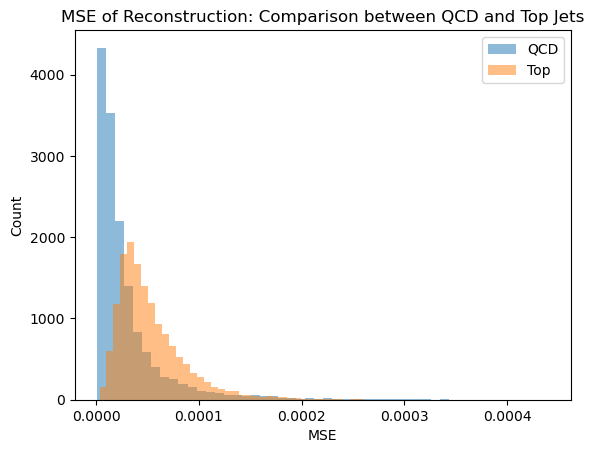

In [202]:
plt.hist(qcd_mse.detach().cpu(), bins=50, alpha=0.5, label="QCD");
plt.hist(top_mse.detach().cpu(), bins=50, alpha=0.5, label="Top");
plt.legend();
plt.xlabel("MSE")
plt.ylabel("Count")
plt.title("MSE of Reconstruction: Comparison between QCD and Top Jets")

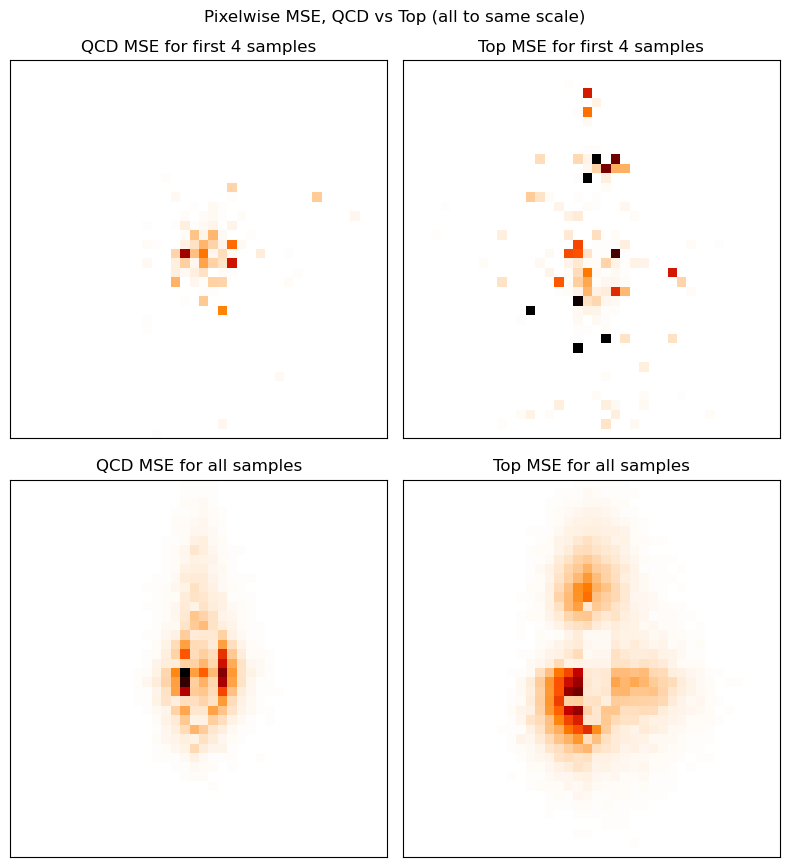

In [203]:
fig, axes = plt.subplots(2, 2, figsize=(8, 9))
vmin = 0
vmax = torch.stack(
    [
        pixelwise_mse(qcd_samples, qcd_reconstruction, -1),
        pixelwise_mse(top_samples, top_reconstruction, -1)]
    ).max()
axes[0, 0].imshow(
    pixelwise_mse(qcd_samples, qcd_reconstruction),
    vmin=vmin,
    vmax=vmax,
    cmap="gist_heat_r"
)
axes[0, 0].set_title("QCD MSE for first 4 samples")
axes[0, 1].imshow(
    pixelwise_mse(top_samples, top_reconstruction),
    vmin=vmin,
    vmax=vmax,
    cmap="gist_heat_r"
)
axes[0, 1].set_title("Top MSE for first 4 samples")
axes[1, 0].imshow(
    pixelwise_mse(qcd_samples, qcd_reconstruction, amount=-1),
    vmin=vmin,
    vmax=vmax,
    cmap="gist_heat_r"
)
axes[1, 0].set_title("QCD MSE for all samples")
axes[1, 1].imshow(
    pixelwise_mse(top_samples, top_reconstruction, amount=-1),
    vmin=vmin,
    vmax=vmax,
    cmap="gist_heat_r"
)
axes[1, 1].set_title("Top MSE for all samples")

for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

plt.suptitle("Pixelwise MSE, QCD vs Top (all to same scale)")
plt.tight_layout()

In [204]:
y_test_reconstruction = modelCNN(torch.Tensor(z_test)).reshape(-1, 40, 40)
y_test_mse = torch.mean((torch.Tensor(z_test).reshape(-1, 40, 40) - y_test_reconstruction)**2, dim=(1, 2))
y_test_mse = y_test_mse.detach().cpu().numpy()

In [205]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_mse)
auc_score = roc_auc_score(y_test, y_test_mse)

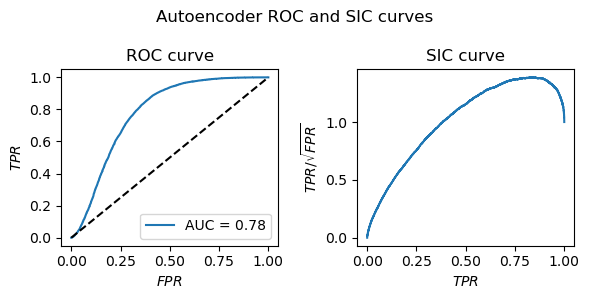

In [206]:
# create figure and two subplots
fig, ax = plt.subplots(1, 2, figsize=(6, 3))

# plot ROC curve
ax[0].plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
ax[0].plot([0, 1], [0, 1], "--", color="black")
ax[0].set_title("ROC curve")
ax[0].set_xlabel("$FPR$")
ax[0].set_ylabel("$TPR$")
ax[0].legend(loc='lower right')

# plot SIC curve
ax[1].plot(tpr[fpr != 0], tpr[fpr != 0]/np.sqrt(fpr[fpr != 0]))
ax[1].set_title("SIC curve")
ax[1].set_xlabel("$TPR$")
ax[1].set_ylabel("$TPR/\sqrt{{FPR}}$")

plt.suptitle("Autoencoder ROC and SIC curves")

plt.tight_layout()
plt.show()

### (f)

In [ ]:
# TODO: Repeat everything for autoencoder trained on top jets
# You can either use a MLP or a CNN